### Find Best ensemble

Run this code if you need to find the best ensemble among different models combinations. 
Check "top_model" above in this notebook, it's under the "Ensemble" markdown.

In [1]:
# This notebook is used to
# 1. Refine the classifiers to mitigate data imbalance
# 2. Create ensemble classifier
# 3. Perform feature ablation

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})

# suppress sklearn deprecated warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

In [25]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 32
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = dropped_na_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/{n_features}features/{key if extra_path else '' }"
print(path_models)
print(path)

models/32features/dropped_na/
data/32features/dropped_na/


In [26]:
# Read data
df_train = pd.read_csv(f"{path}train.csv", index_col=0)
df_valid = pd.read_csv(f"{path}valid.csv", index_col=0)
df_test = pd.read_csv(f"{path}test.csv", index_col=0)

train, valid, test = df_train.to_numpy(), df_valid.to_numpy(), df_test.to_numpy()
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
feat_names = list(df_train.columns)

from collections import Counter
print(Counter(y_train))
print(Counter(y_valid))
print(Counter(y_test))

# All the numerical features that can be standarditazed
from utils import get_preprocess_std_num
preprocess_std = get_preprocess_std_num(feat_names)
preprocess_std_all = StandardScaler()

# Preprocessed ready-to-use train and valid set
process_tmp = preprocess_std.fit(X_train)
X_train_std = process_tmp.transform(X_train)
X_valid_std = process_tmp.transform(X_valid)

Counter({1.0: 3216, 0.0: 427})
Counter({1.0: 1072, 0.0: 143})
Counter({1.0: 1073, 0.0: 142})


['knn', 'svc', 'adaboost', 'xgb', 'gb', 'lr', 'nn', 'rf']
['knn_random_svmsmote_knn', 'rf_random_svmsmote_rf', 'gb_random_smote_gb', 'nn_random_svmsmote_nn', 'lr_random_svmsmote_lr', 'svc_random_svmsmote_svc', 'adaboost_random_svmsmote_adaboost', 'xgb_random_bordersmote_xgb']
##############################################
 Rank: #1 Names: ('rf_random_svmsmote_rf', 'gb_random_smote_gb', 'nn_random_svmsmote_nn', 'svc_random_svmsmote_svc', 'adaboost_random_svmsmote_adaboost'), Score: (0.7137400845423234, 0.9383974062065772, 0.1094650205761317)
##############################################
 Rank: #2 Names: ('rf_random_svmsmote_rf', 'gb_random_smote_gb', 'nn_random_svmsmote_nn'), Score: (0.7102435810458199, 0.9379629629629629, 0.1102880658436214)
##############################################
 Rank: #3 Names: ('rf_random_svmsmote_rf', 'gb_random_smote_gb', 'nn_random_svmsmote_nn', 'adaboost_random_svmsmote_adaboost'), Score: (0.7102435810458199, 0.9379629629629629, 0.1102880658436214)
####

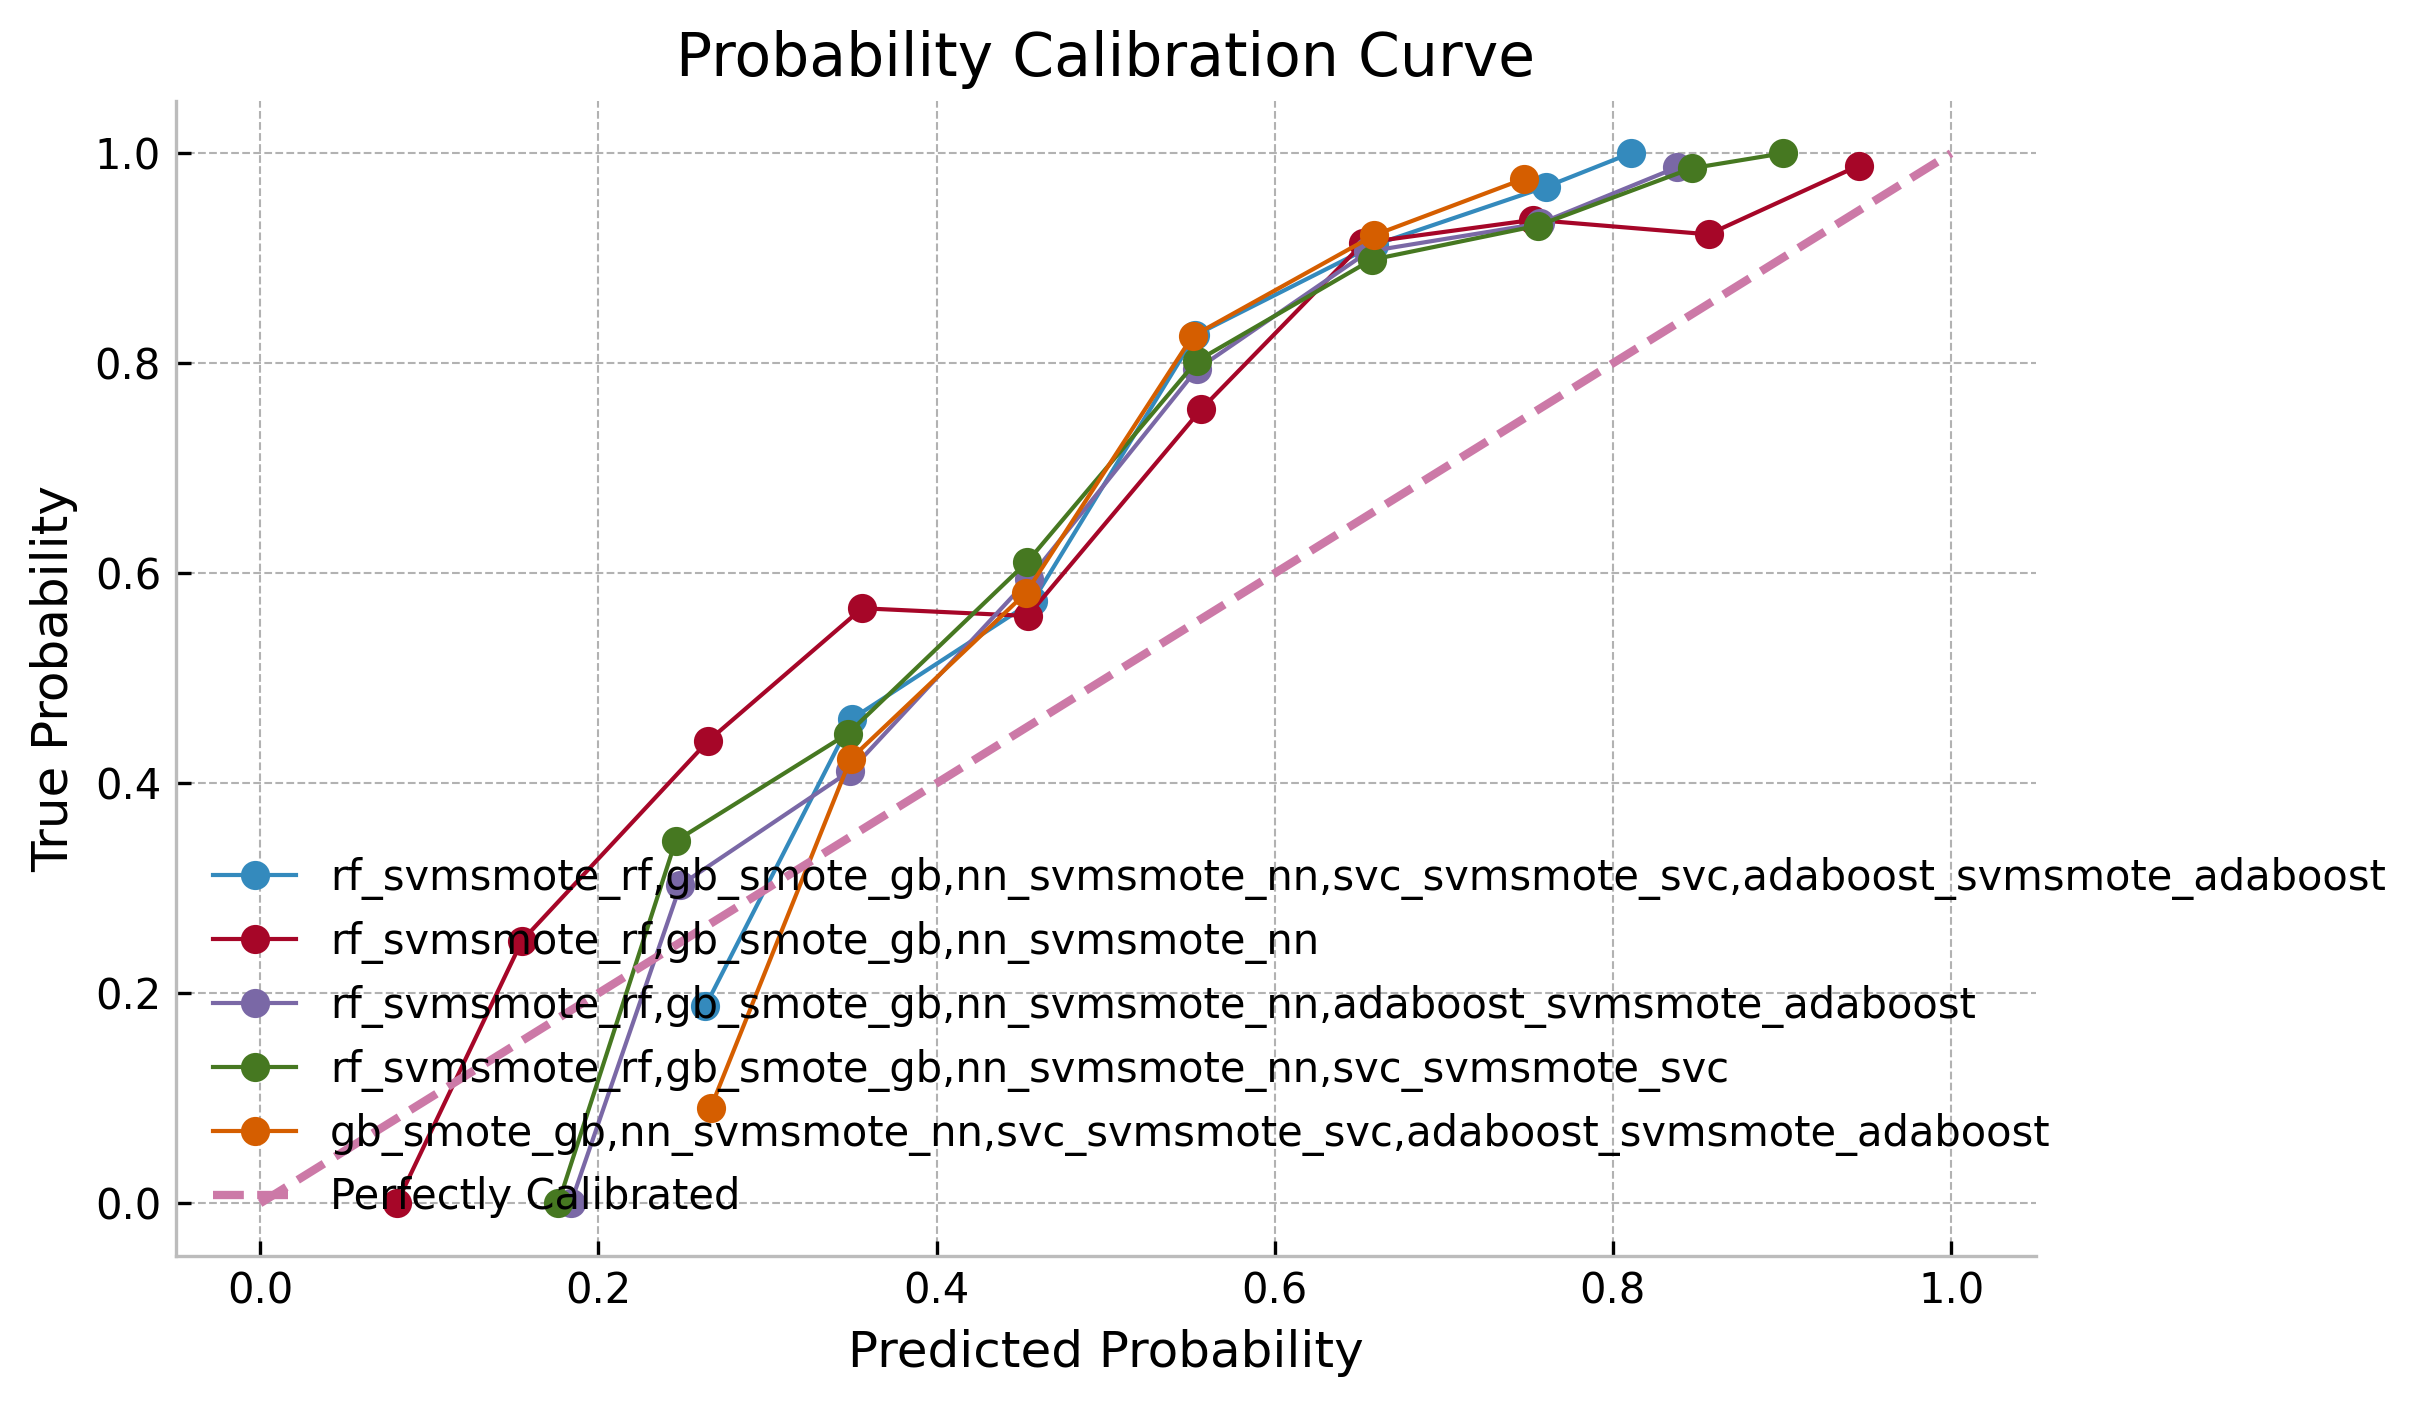

In [28]:
from ensemble import predict_ensemble, find_best_ensemble
from contextlib import redirect_stdout
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path_models) if isfile(join(path_models, f))]
onlyfiles = [model.replace('.joblib', '') for model in onlyfiles]
onlyfiles = [x for x in onlyfiles if not x.startswith('.')]
models = list(filter(lambda x: "random" not in x, onlyfiles))
smote_models = list(filter(lambda x: "random" in x, onlyfiles))
print(models)
print(smote_models)
# Select the list by flipping this variable, this variable it's also used to save the plot in the correct path 
selected = smote_models
ensemble = find_best_ensemble(selected,path_models, X_valid, y_valid, False)

from sklearn.calibration import calibration_curve
for names, model, score in ensemble[:5]:
    train_prob, train_pred = predict_ensemble(model, X_train, y_train)
    valid_prob, valid_pred = predict_ensemble(model, X_valid, y_valid)
    test_prob, test_pred = predict_ensemble(model, X_test, y_test)
    
    print(sum(y_train == train_pred) / len(df_train))
    print(sum(y_valid == valid_pred) / len(df_valid))
    print(sum(y_test == test_pred) / len(df_test))
    
    df_train["ModelOutput"] = train_prob[:, 1]
    df_valid["ModelOutput"] = valid_prob[:, 1]
    df_test["ModelOutput"] = test_prob[:, 1]
    true_pos, pred_pos = calibration_curve(y_test, test_prob[:, 1], n_bins=10)
    plt.plot(pred_pos,
             true_pos, 
             marker='o', 
             linewidth=1, 
             label=",".join(names).replace("_random",''))
    

plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')
suffix = "" if selected == models else "_sampling"
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')
plt.savefig(f"{path_images}calibration_top_five{suffix}.png")
index = 1
with open(f"{path_images}calibration_top_five{suffix}.txt", 'a+') as f:
        with redirect_stdout(f):
            for names, model, score in ensemble[:5]:
                print("##############################################")
                print (f" Rank: #{index} Names: {names}, Score: {score}")
                index +=1